# CycleGAN for Gaussian with Wasserstein Loss
Adaptation of this [paper](https://arxiv.org/pdf/1703.10593.pdf) for inverting a shift between two normally distributed datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the datasets

### Source domain

In [3]:
N_source = 100

In [4]:
mean = [-1, 0]

std = 0.1
cov = np.eye(2) * std

In [5]:
x, y = np.random.multivariate_normal(mean, cov, N_source).T
X_source = np.concatenate([x.reshape(len(x), 1), y.reshape(len(y), 1)], axis=1)

### Target domain

In [6]:
N_target = 100

In [7]:
mean = [1, 0]

std = 0.1
cov = np.eye(2) * std

In [8]:
x, y = np.random.multivariate_normal(mean, cov, N_target).T
X_target = np.concatenate([x.reshape(len(x), 1), y.reshape(len(y), 1)], axis=1)

### Display the dataset

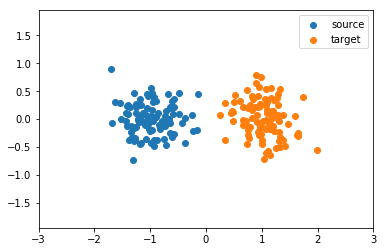

In [9]:
plt.axis("equal")
plt.axis([-3,3,-3,3])

plt.scatter(X_source[:,0], X_source[:,1], label="source")
plt.scatter(X_target[:,0], X_target[:,1], label="target")
plt.legend()

## Create the model

### Placeholders

In [10]:
ipt_source = tf.placeholder(tf.float32, shape=[None, 2], name='ipt_source')
ipt_target = tf.placeholder(tf.float32, shape=[None, 2], name='ipt_target')

### Discriminator Network

In [11]:
def discriminator(x, scope): 
    initializer = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope(scope):
        W1 = tf.get_variable('W1', shape=[2,10], initializer=initializer)
        b1 = tf.get_variable('b1', shape=[10], initializer=initializer)

        W2 = tf.get_variable('W2', shape=[10, 10], initializer=initializer)
        b2 = tf.get_variable('b2', shape=[10], initializer=initializer)

        W3 = tf.get_variable('W3', shape=[10, 1], initializer=initializer)
        b3 = tf.get_variable('b3', shape=[1], initializer=initializer)
        
        h1 = tf.nn.relu(tf.matmul(x, W1) + b1)
        h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
        h3 = tf.matmul(h2, W3) + b3
        #prob = tf.nn.sigmoid(h3)
    
    return h3

### Generator Network

In [12]:
def generator(x, scope):
    with tf.variable_scope(scope, reuse=None):
        W1 = tf.get_variable('W1', initializer=tf.eye(2, dtype="float32"))
        b1 = tf.get_variable('b1', shape=[2], initializer=tf.zeros_initializer())
        G_output = tf.matmul(x, W1) + b1
    
    return G_output

### Losses and solver

#### Useful functions

In [13]:
def log(tensor):
    return tf.log(tf.maximum(tensor, 1e-9))

#### Define the graph

In [14]:
with tf.variable_scope("s2t") as scope:
    D_target = discriminator(ipt_target, "discriminator")
    G_source = generator(ipt_source, "generator")
    scope.reuse_variables()
    DG_source = discriminator(G_source, "discriminator")

In [15]:
with tf.variable_scope("t2s") as scope:
    D_source = discriminator(ipt_source, "discriminator")
    G_target = generator(ipt_target, "generator")
    scope.reuse_variables()
    DG_target = discriminator(G_target, "discriminator")

In [16]:
with tf.variable_scope("s2t", reuse=True) as scope:
    cyc_target = generator(G_target, "generator")

In [17]:
with tf.variable_scope("t2s", reuse=True) as scope:
    cyc_source = generator(G_source, "generator")

#### Losses

In [18]:
lambda_cyc = 10
lambda_pen = 100

In [19]:
cyc_loss = tf.losses.mean_squared_error(ipt_source, cyc_source) + tf.losses.mean_squared_error(ipt_target, cyc_target)
tf.summary.scalar("cyc_loss", cyc_loss)

<tf.Tensor 'cyc_loss:0' shape=() dtype=string>

In [20]:
with tf.variable_scope("grad-pen-s2t"):
    eps = tf.random_uniform([40, 1], minval=0., maxval=1.)
    X_inter = eps*ipt_target + (1. - eps)*G_source
    grad = tf.gradients(discriminator(X_inter, "discriminator"), [X_inter])[0]
    grad_norm = tf.sqrt(tf.reduce_sum((grad)**2, axis=1))
    grad_pen_s2t = lambda_pen * tf.reduce_mean((grad_norm - 1)**2)

In [21]:
with tf.variable_scope("grad-pen-t2s"):
    eps = tf.random_uniform([40, 1], minval=0., maxval=1.)
    X_inter = eps*ipt_source + (1. - eps)*G_target
    grad = tf.gradients(discriminator(X_inter, "discriminator"), [X_inter])[0]
    grad_norm = tf.sqrt(tf.reduce_sum(grad**2, axis=1))
    grad_pen_t2s = lambda_pen * tf.reduce_mean((grad_norm - 1)**2)

In [22]:
D_s2t_loss = tf.reduce_mean(DG_source) - tf.reduce_mean(D_target) + grad_pen_s2t
G_s2t_loss = -tf.reduce_mean(DG_source) + lambda_cyc*cyc_loss
tf.summary.scalar("D_s2t_loss", D_s2t_loss)
tf.summary.scalar("G_s2t_loss", G_s2t_loss)

<tf.Tensor 'G_s2t_loss:0' shape=() dtype=string>

In [23]:
D_t2s_loss = tf.reduce_mean(DG_target) - tf.reduce_mean(D_source) + grad_pen_t2s
G_t2s_loss = -tf.reduce_mean(DG_target) + lambda_cyc*cyc_loss
tf.summary.scalar("D_t2s_loss", D_t2s_loss)
tf.summary.scalar("G_t2s_loss", D_t2s_loss)

<tf.Tensor 'G_t2s_loss:0' shape=() dtype=string>

#### Solvers

In [24]:
model_vars = tf.trainable_variables()

D_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/discriminator')
G_s2t_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='s2t/generator')
D_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/discriminator')
G_t2s_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='t2s/generator')

In [71]:
D_s2t_solver = tf.train.AdamOptimizer(learning_rate=1e-2, beta1=0, beta2=0.9).minimize(D_s2t_loss, var_list=D_s2t_vars)
G_s2t_solver = tf.train.AdamOptimizer(learning_rate=1e-2, beta1=0, beta2=0.9).minimize(G_s2t_loss, var_list=G_s2t_vars)
D_t2s_solver = tf.train.AdamOptimizer(learning_rate=1e-2, beta1=0, beta2=0.9).minimize(D_t2s_loss, var_list=D_t2s_vars)
G_t2s_solver = tf.train.AdamOptimizer(learning_rate=1e-2, beta1=0, beta2=0.9).minimize(G_t2s_loss, var_list=G_t2s_vars)

## Run the model

In [72]:
sess = tf.InteractiveSession()

In [73]:
# import shutil
# shutil.rmtree('log-gaussian/')

In [74]:
# summary_writer = tf.summary.FileWriter('log-gaussian/', sess.graph)

In [75]:
# merged_summary = tf.summary.merge_all()

In [76]:
sess.run(tf.global_variables_initializer())
D_s2t_loss_list = []
G_s2t_loss_list = []
D_t2s_loss_list = []
G_t2s_loss_list = []
iter_list = []
i = 0

In [77]:
nb_iter = 100
nb_iter_d = 5
nb_iter_g = 1
nb_samples = 40
G_s2t_loss_curr = 0.001
D_s2t_loss_curr = 0.001
G_t2s_loss_curr = 0.001
D_t2s_loss_curr = 0.001

for i in range(i, nb_iter+i):
    for k in range(nb_iter_g):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        
        ## Optimizing s2t
        _, G_s2t_loss_curr = sess.run([G_s2t_solver, G_s2t_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
        ## Optimizing t2s
        _, G_t2s_loss_curr = sess.run([G_t2s_solver, G_t2s_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
        
    for k in range(nb_iter_d):
        sample_source = X_source[np.random.choice(len(X_source), nb_samples)]
        sample_target = X_target[np.random.choice(len(X_target), nb_samples)]
        
        ## Optimizing s2t
        _, D_s2t_loss_curr = sess.run([D_s2t_solver, D_s2t_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
        ## Optimizing t2s
        _, D_t2s_loss_curr = sess.run([D_t2s_solver, D_t2s_loss], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    
    iter_list.append(i)
    cyc_loss_curr, summary = sess.run([cyc_loss, merged_summary], feed_dict={ipt_source: sample_source, ipt_target: sample_target})
    D_s2t_loss_list.append(D_s2t_loss_curr)
    G_s2t_loss_list.append(G_s2t_loss_curr)
    D_t2s_loss_list.append(D_t2s_loss_curr)
    G_t2s_loss_list.append(G_t2s_loss_curr)
#     summary_writer.add_summary(summary, i)
    
    if i % (nb_iter//5) == 0:
        print('Iter: {}'.format(i))
        print('D loss s2t: {:.4}'.format(D_s2t_loss_curr))
        print('G loss s2t: {:.4}'.format(G_s2t_loss_curr))
        print('D loss t2s: {:.4}'.format(D_t2s_loss_curr))
        print('G loss t2s: {:.4}'.format(G_t2s_loss_curr))
        print('Cycle-loss: {:.4}'.format(cyc_loss_curr))
        print()
        
summary_writer.flush()

Iter: 0
D loss s2t: 45.42
G loss s2t: -0.7818
D loss t2s: 26.69
G loss t2s: 0.09984
Cycle-loss: 0.0004365

Iter: 20
D loss s2t: -191.0
G loss s2t: 120.0
D loss t2s: -124.0
G loss t2s: 82.54
Cycle-loss: 0.2621

Iter: 40
D loss s2t: -519.3
G loss s2t: 367.4
D loss t2s: -354.2
G loss t2s: 157.4
Cycle-loss: 0.3409

Iter: 60
D loss s2t: -94.38
G loss s2t: 202.2
D loss t2s: -158.1
G loss t2s: 12.12
Cycle-loss: 0.1212

Iter: 80
D loss s2t: 71.66
G loss s2t: 1.08e+03
D loss t2s: 62.05
G loss t2s: 502.4
Cycle-loss: 0.1916



## Display the results

In [78]:
X_source_trans = sess.run(G_source, feed_dict={ipt_source: X_source})
X_target_trans = sess.run(G_target, feed_dict={ipt_target: X_target})
X_source_cyc = sess.run(cyc_source, feed_dict={ipt_source: X_source})

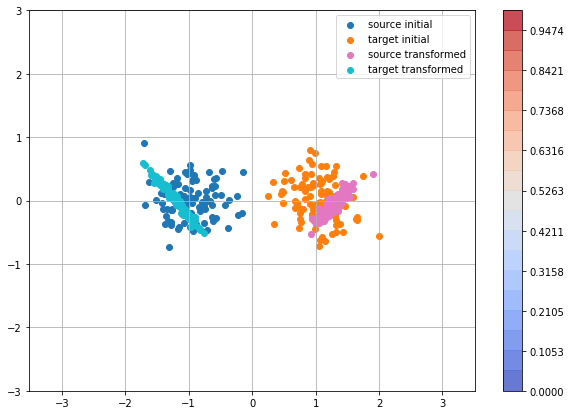

In [79]:
#plt.rcParams['figure.figsize'] = (10, 15)
plt.rcParams['figure.figsize'] = (10, 7)
plt.axes().set_aspect('equal', 'datalim')
plt.axis([-3,3,-3,3])

x_min, x_max = -4, 4
y_min, y_max = -4, 4
h = .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

levels = np.linspace(0,1,20)
cm = plt.cm.coolwarm
Z = sess.run(D_target, feed_dict={ipt_target: np.c_[xx.ravel(), yy.ravel()]}).reshape(xx.shape)

#f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[10, 10]})

cont = plt.contourf(xx, yy, Z, levels, cmap=cm, alpha=.8)

plt.scatter(X_source[:,0], X_source[:,1], label="source initial")
plt.scatter(X_target[:,0], X_target[:,1], label="target initial")
plt.scatter(X_source_trans[:,0], X_source_trans[:,1], label="source transformed", color=colormap[6])
plt.scatter(X_target_trans[:,0], X_target_trans[:,1], label="target transformed", color=colormap[9])
#plt.scatter(X_source_cyc[:,0], X_source_cyc[:,1], label="Source cycle", color=colormap[8])

plt.legend()
#cax = f.add_axes([0.91,0.53,0.05,0.35])
# plt.colorbar(cont, cax=cax, orientation="vertical")
plt.colorbar(cont, orientation="vertical")
plt.grid()
# plt.savefig('screenshots/adda-step-77')
#a1.plot(D_loss_list, label="Discriminator loss")
#a1.plot(T_loss_list, label="Generator loss")
#a1.legend()

## Debug

### Learning curves

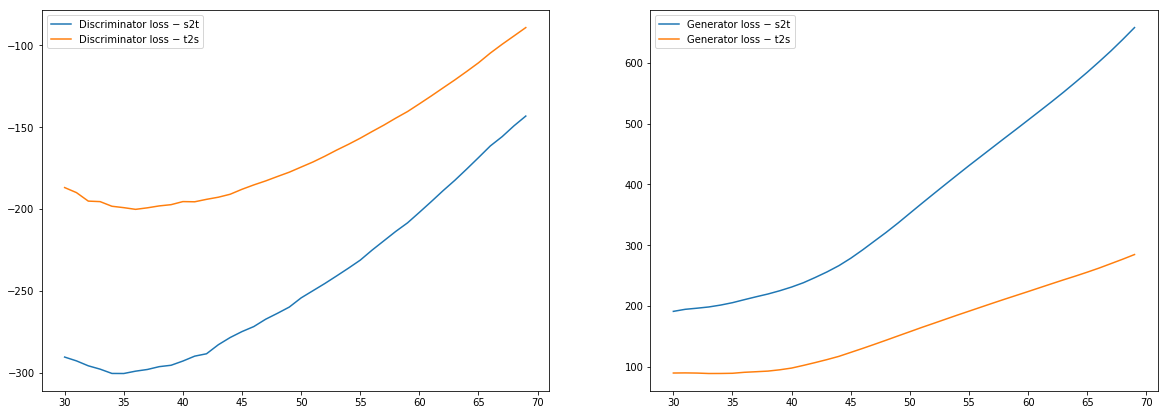

In [80]:
k = 30
def smooth(x_list):
    return np.array([1/(2*k) * np.sum([x_list[i+j] for j in range(-k, k)]) for i in range(k, len(x_list)-k)])

plt.rcParams['figure.figsize'] = (20, 7)

plt.subplot(1,2,1)
plt.plot(iter_list[k:-k], smooth(D_s2t_loss_list), label="Discriminator loss − s2t")
plt.plot(iter_list[k:-k], smooth(D_t2s_loss_list), label="Discriminator loss − t2s")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_list[k:-k], smooth(G_s2t_loss_list), label="Generator loss − s2t")
plt.plot(iter_list[k:-k], smooth(G_t2s_loss_list), label="Generator loss − t2s")
plt.legend()

### GP Losses

In [81]:
loss_gp_s2t = sess.run(grad_pen_s2t/lambda_pen, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print(loss_gp_s2t)

0.226253


In [82]:
loss_gp_t2s = sess.run(grad_pen_t2s/lambda_pen, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print(loss_gp_t2s)

0.292399


### Cycle Losses

In [83]:
loss_cycle = sess.run(cyc_loss/lambda_cyc, feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print(loss_cycle)

0.0257453


### Other losses

In [84]:
loss_DG_source = sess.run(tf.reduce_mean(DG_source), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print(loss_DG_source)

-1573.98


In [85]:
loss_D_target = sess.run(tf.reduce_mean(D_target), feed_dict={ipt_source: sample_source, ipt_target: sample_target})
print(loss_D_target)

-1451.14


### Gradients

In [86]:
for var in D_s2t_vars:
    print (sess.run(tf.sqrt(tf.reduce_sum(tf.gradients(D_s2t_loss, var)[0]**2)), 
                    feed_dict={ipt_source: sample_source, ipt_target: sample_target}))

37.6364
13.6106
18.6323
0.735657
13.0582
0.0


In [87]:
for var in D_t2s_vars:
    print (sess.run(tf.sqrt(tf.reduce_sum(tf.gradients(D_t2s_loss, var)[0]**2)), 
                    feed_dict={ipt_source: sample_source, ipt_target: sample_target}))

29.9016
9.86746
13.6412
0.646295
5.26843
0.0


In [88]:
for var in G_s2t_vars:
    print (sess.run(tf.sqrt(tf.reduce_sum(tf.gradients(G_s2t_loss, var)[0]**2)), 
                    feed_dict={ipt_source: sample_source, ipt_target: sample_target}))

222.924
262.64


In [89]:
for var in G_t2s_vars:
    print (sess.run(tf.sqrt(tf.reduce_sum(tf.gradients(G_t2s_loss, var)[0]**2)), 
                    feed_dict={ipt_source: sample_source, ipt_target: sample_target}))

72.1878
48.085


In [90]:
for var in G_s2t_vars+D_s2t_vars:
    print (sess.run(tf.sqrt(tf.reduce_sum(tf.gradients(tf.reduce_mean(DG_source), var)[0]**2)), 
                    feed_dict={ipt_source: sample_source, ipt_target: sample_target}))

218.404
259.267
164.291
126.729
107.241
8.3039
190.812
1.0
